In [2]:
from pytorch_lightning import Trainer
import torch
import numpy as np
from sunbird.models import FCN
from sunbird.data import DSDataModule
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
#from sunbird.models.density_split import DensitySplit

In [3]:
%load_ext autoreload

In [4]:
plt.rcParams['figure.dpi'] = 300


In [5]:
plt.style.use(['science', 'no-latex'])


In [62]:
def get_errors(quintile,):
    data = np.load('../data/full_ap/clustering/ds/ds_cross_xi_smu_zsplit_Rs20_c000_ph000.npy', allow_pickle=True).item()
    s = data['s']
    covariance = np.load('../data/full_ap/covariance/ds_cross_xi_smu_zsplit_Rs20_landyszalay_randomsX50.npy', allow_pickle=True).item()
    combined_multipoles = covariance['multipoles'][:,quintile, :2].reshape((len(covariance['multipoles']),-1))
    mean_value = np.mean(combined_multipoles,axis=0)#covariance['multipoles'][:, quintile,0],axis=0)
    covariance = np.cov(combined_multipoles.T)#covariance['multipoles'][:,quintile,0].T)
    return s, np.sqrt(np.diag(covariance)), np.sqrt(np.diag(covariance)) / mean_value

In [54]:
!ls ../data/full_ap/covariance

ds_cross_xi_smu_zsplit_Rs20_landyszalay_randomsX50.npy
xi_smu_landyszalay_randomsX50.npy


In [55]:
trainer = Trainer()

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [60]:
def get_true_and_pred(trainer, quintile,):
    dm = DSDataModule(statistic=f'ds{quintile}', normalize=True, normalize_inputs=True)
    dm.setup('test')
    model = FCN.from_folder(
        f'../trained_models/ds{quintile}_full/version_0/'#best/ds{quintile}_m0//',
    )
    predictions = trainer.predict(model, dm.test_dataloader())
    predictions = torch.concat(predictions).numpy()
    truth = dm.ds_test.tensors[1].numpy()
    return truth, predictions

In [61]:
errors, scaled_errors, truths, preds = [], [], [], []
for i, quintile in enumerate([0,1,3,4]):
    s, err, scaled_err = get_errors(quintile)
    errors.append(err)
    scaled_errors.append(scaled_err)
    truth, pred = get_true_and_pred(trainer, quintile)
    truths.append(truth)
    preds.append(pred)

errors = np.array(errors)
scaled_errors = np.array(scaled_errors)
truths = np.array(truths)
preds = np.array(preds)


(1000, 3, 34)
(1000, 68)


/n/home11/ccuestalazaro/.conda/envs/geometric/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:236: PossibleUserWarning: The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Predicting: 0it [00:00, ?it/s]

(1000, 3, 34)
(1000, 68)


Predicting: 0it [00:00, ?it/s]

(1000, 3, 34)
(1000, 68)


Predicting: 0it [00:00, ?it/s]

(1000, 3, 34)
(1000, 68)


Predicting: 0it [00:00, ?it/s]

In [63]:
standard_errors = (preds - truths)/errors.reshape((len(errors), 1, errors.shape[-1]))
percent_errors = (preds - truths)/truths

/n/home11/ccuestalazaro/tmp/ipykernel_145680/956986112.py:2: RuntimeWarning: divide by zero encountered in divide
  percent_errors = (preds - truths)/truths


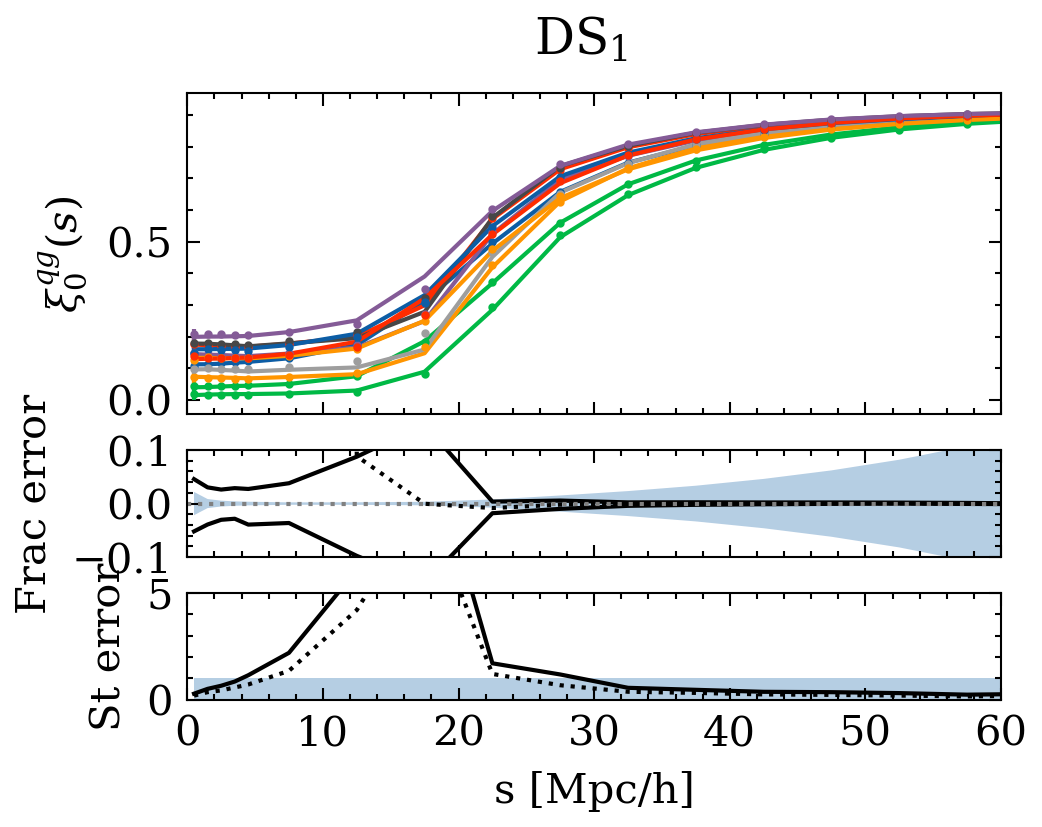

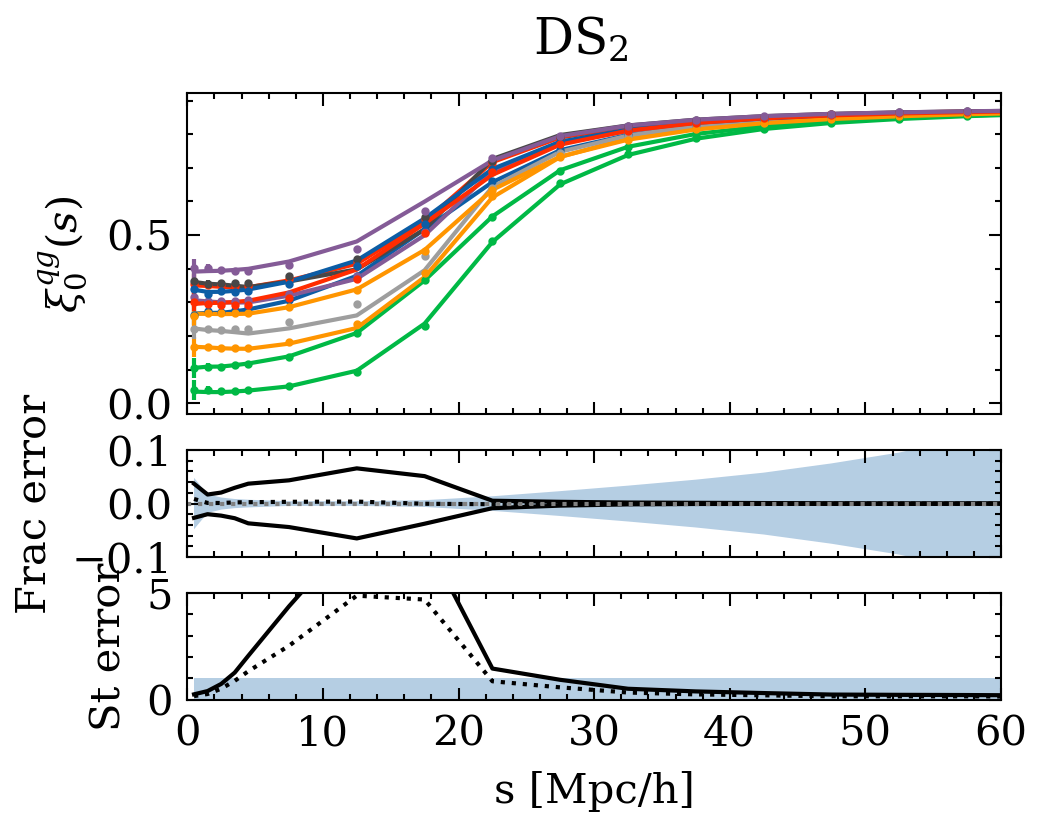

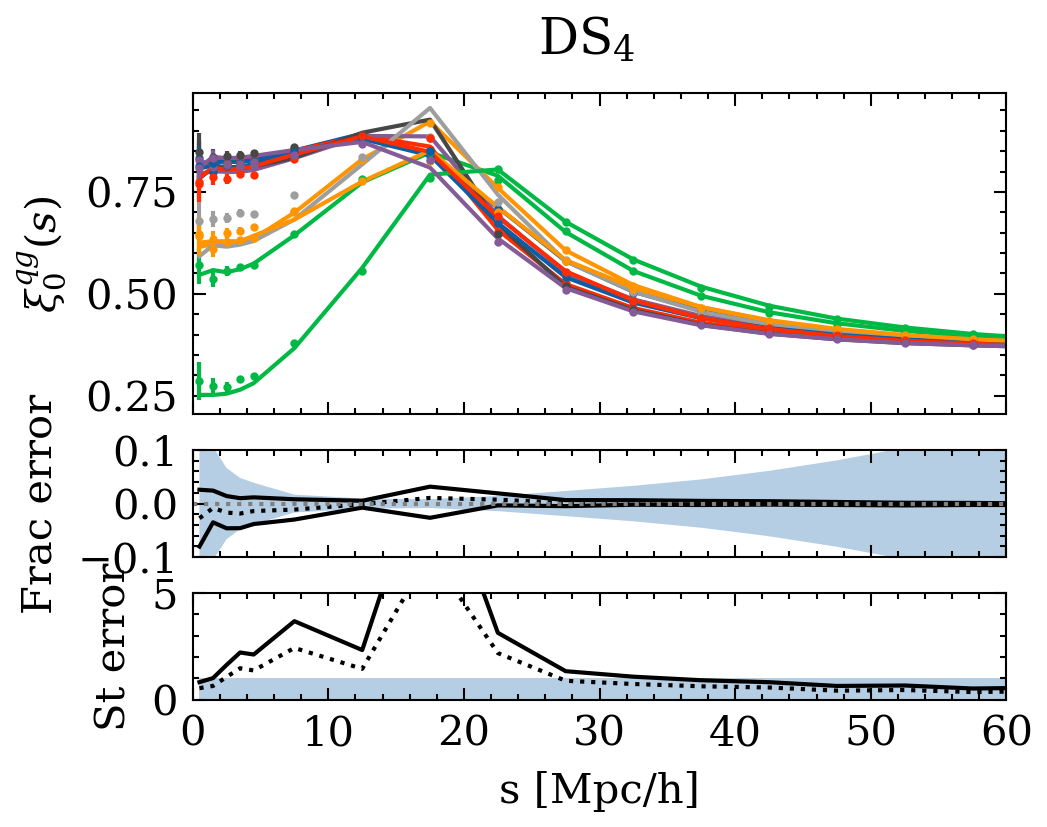

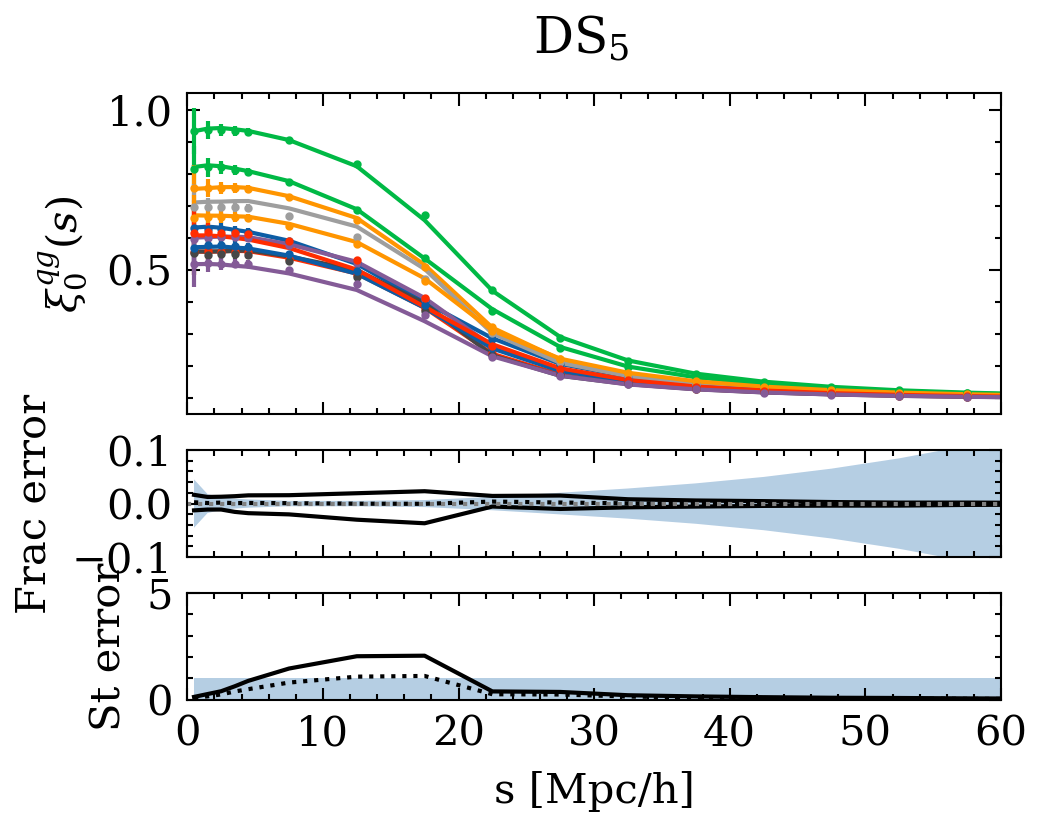

In [72]:
for i, quintile in enumerate([0,1,3,4]):
    fig, ax = plt.subplots(
        nrows=3, 
        gridspec_kw={'height_ratios': [3, 1, 1]}, 
        sharex=True,
    )
    for j in range(0,truths.shape[1], 600):
        c = ax[0].errorbar(s, truths[i,j][:len(s)], yerr=errors[i][:len(s)], linestyle='', marker='o', markersize=1)
        ax[0].plot(s, preds[i,j][:len(s)], color=c[0].get_color())
    mean_error = np.mean(percent_errors[i], axis=0)
    err_frac_p16 = np.percentile(percent_errors[i], 16, axis=0)
    err_frac_p84 = np.percentile(percent_errors[i], 84, axis=0)
    err_frac_inner68 = (err_frac_p84 - err_frac_p16)/2.0
    ax[1].plot(s, mean_error[:len(s)], color='black', linestyle='dotted')
    ax[1].plot(s, err_frac_p16[:len(s)], color='black')
    ax[1].plot(s,  err_frac_p84[:len(s)], color='black')
    ax[1].fill_between(s, -scaled_errors[i][:len(s)], scaled_errors[i][:len(s)], alpha=0.3)
    ax[1].axhline(y=0, color='gray', linestyle='dotted')
    ax[1].set_ylim(-0.1,0.1)


    ax[0].set_xlim(0,60)

    err_68 = np.percentile(np.abs(standard_errors[i]), 68, axis=0)
    ax[2].plot(s, np.median(np.abs(standard_errors[i]),axis=0)[:len(s)], color='black', linestyle='dotted')
    ax[2].plot(s, err_68[:len(s)],
               color='black',) 

    ax[2].fill_between(s, 0, 1, alpha=0.3)
    ax[2].set_ylim(0,5)
    fig.suptitle(f'$\mathrm{{DS}}_{quintile+1}$')
    ax[2].set_xlabel('s [Mpc/h]')
    ax[1].set_ylabel('Frac error')
    ax[2].set_ylabel('St error')
    ax[0].set_ylabel(r'$\xi^{{qg}}_{{0}}(s)$')
    plt.show()



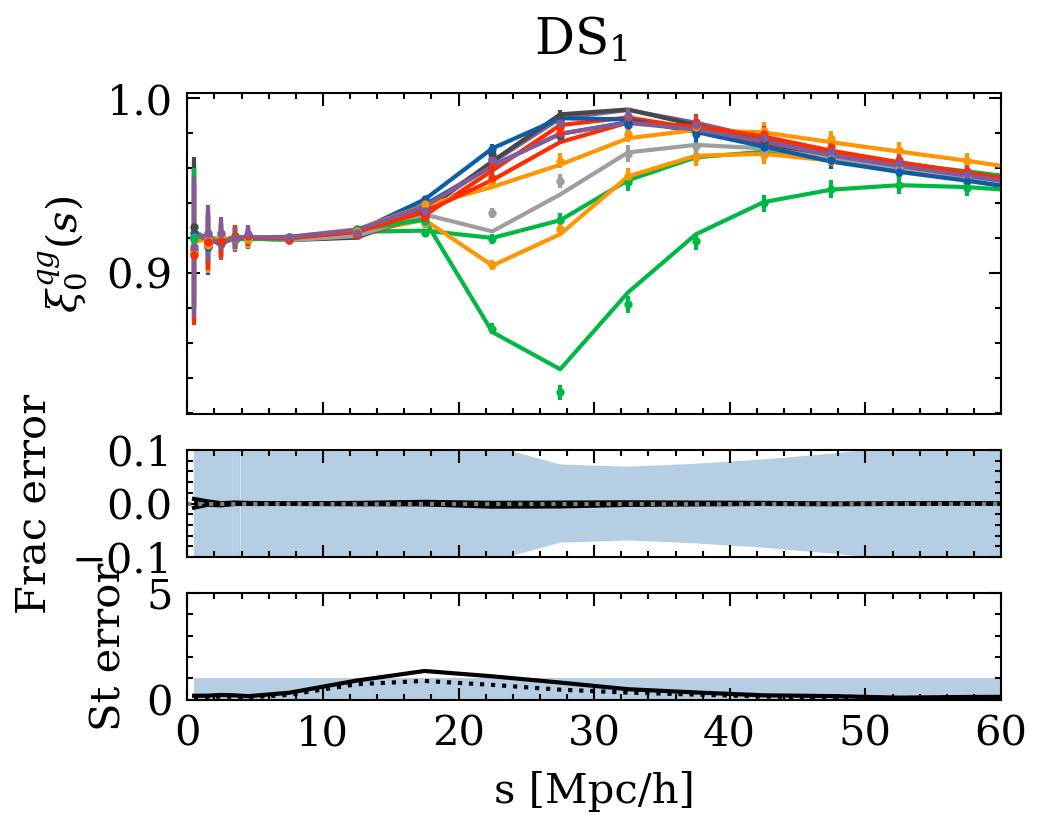

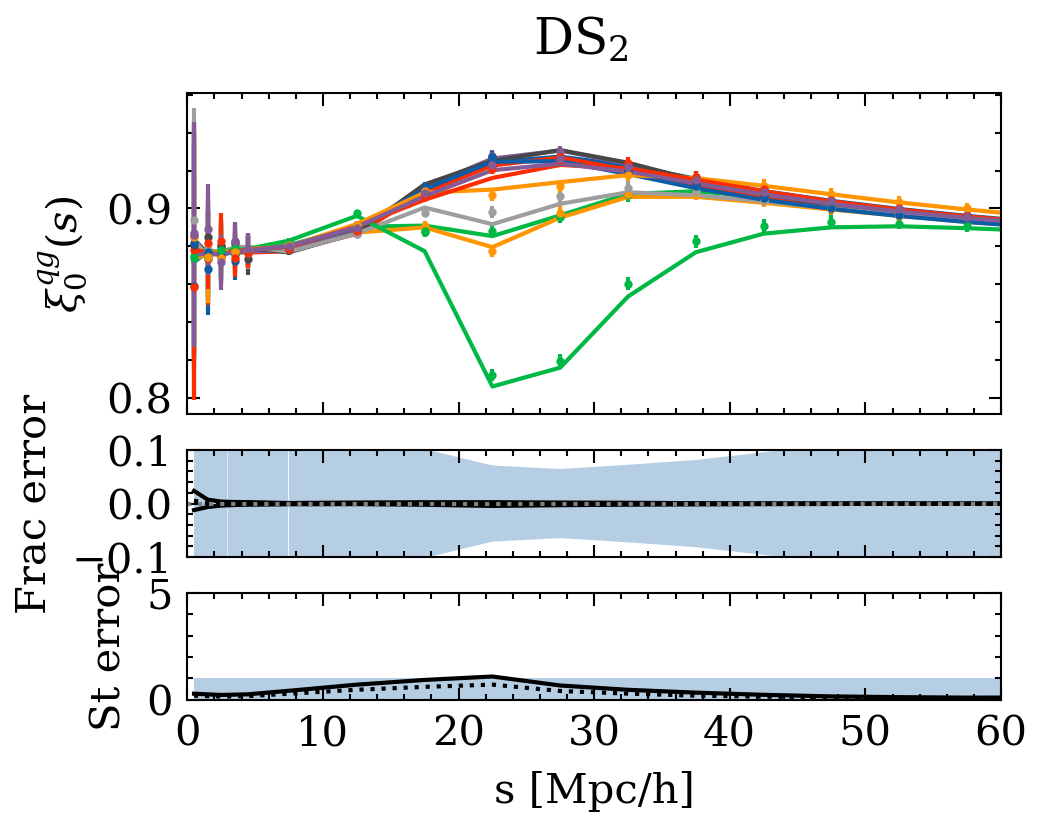

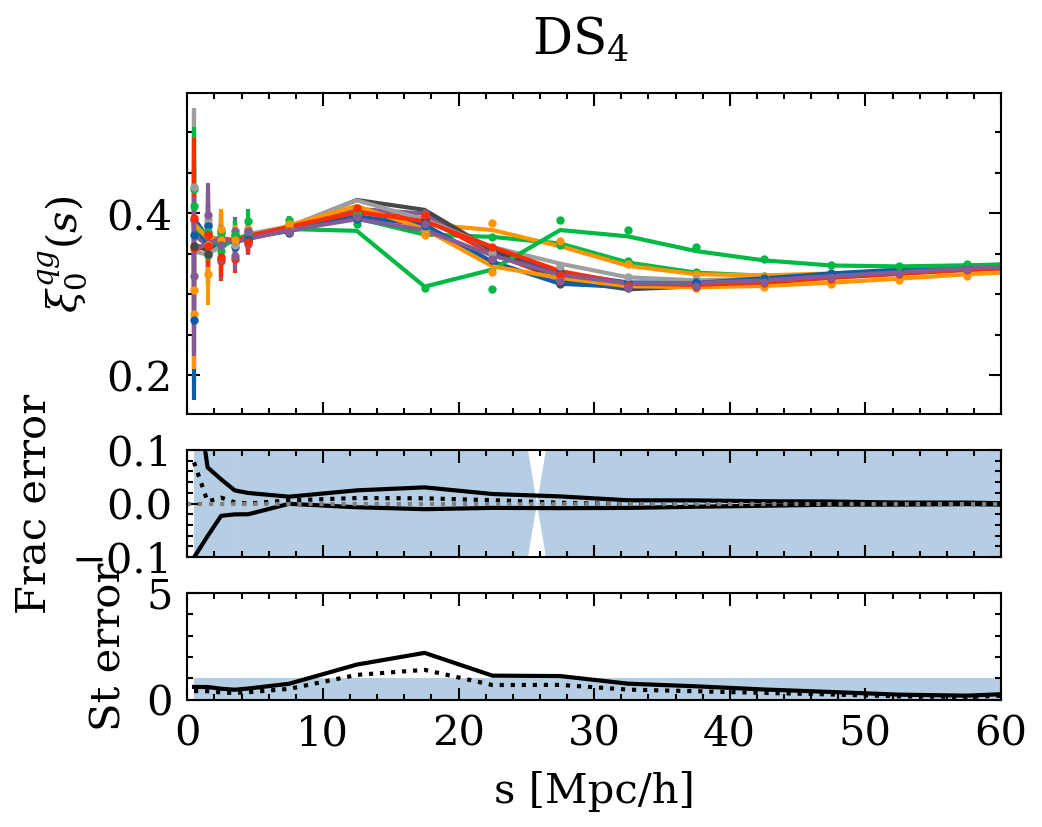

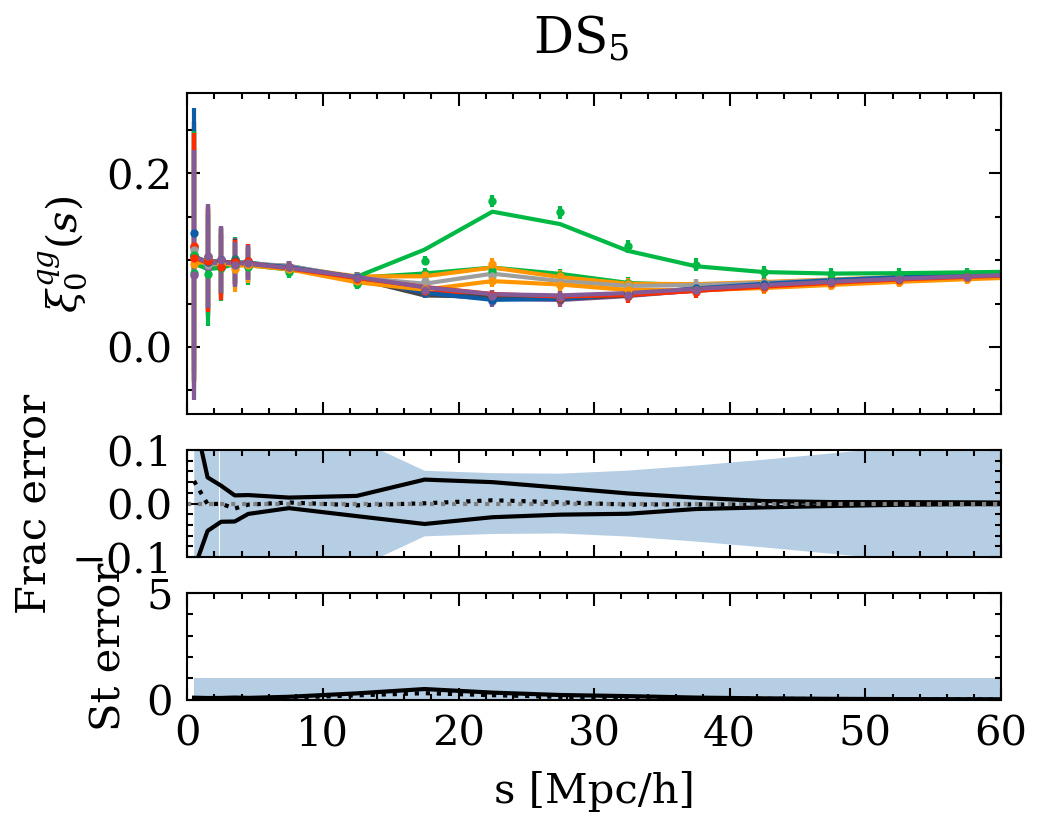

In [68]:
for i, quintile in enumerate([0,1,3,4]):
    fig, ax = plt.subplots(
        nrows=3, 
        gridspec_kw={'height_ratios': [3, 1, 1]}, 
        sharex=True,
    )
    for j in range(0,truths.shape[1], 600):
        c = ax[0].errorbar(s, truths[i,j][len(s):], yerr=errors[i][len(s):], linestyle='', marker='o', markersize=1)
        ax[0].plot(s, preds[i,j][len(s):], color=c[0].get_color())
    mean_error = np.mean(percent_errors[i], axis=0)
    err_frac_p16 = np.percentile(percent_errors[i], 16, axis=0)
    err_frac_p84 = np.percentile(percent_errors[i], 84, axis=0)
    err_frac_inner68 = (err_frac_p84 - err_frac_p16)/2.0
    ax[1].plot(s, mean_error[len(s):], color='black', linestyle='dotted')
    ax[1].plot(s, err_frac_p16[len(s):], color='black')
    ax[1].plot(s,  err_frac_p84[len(s):], color='black')
    ax[1].fill_between(s, -scaled_errors[i][len(s):], scaled_errors[i][len(s):], alpha=0.3)
    ax[1].axhline(y=0, color='gray', linestyle='dotted')
    ax[1].set_ylim(-0.1,0.1)


    ax[0].set_xlim(0,60)

    err_68 = np.percentile(np.abs(standard_errors[i]), 68, axis=0)
    ax[2].plot(s, np.median(np.abs(standard_errors[i]),axis=0)[len(s):], color='black', linestyle='dotted')
    ax[2].plot(s, err_68[len(s):],
               color='black',) 

    ax[2].fill_between(s, 0, 1, alpha=0.3)
    ax[2].set_ylim(0,5)
    fig.suptitle(f'$\mathrm{{DS}}_{quintile+1}$')
    ax[2].set_xlabel('s [Mpc/h]')
    ax[1].set_ylabel('Frac error')
    ax[2].set_ylabel('St error')
    ax[0].set_ylabel(r'$\xi^{{qg}}_{{0}}(s)$')
    plt.show()



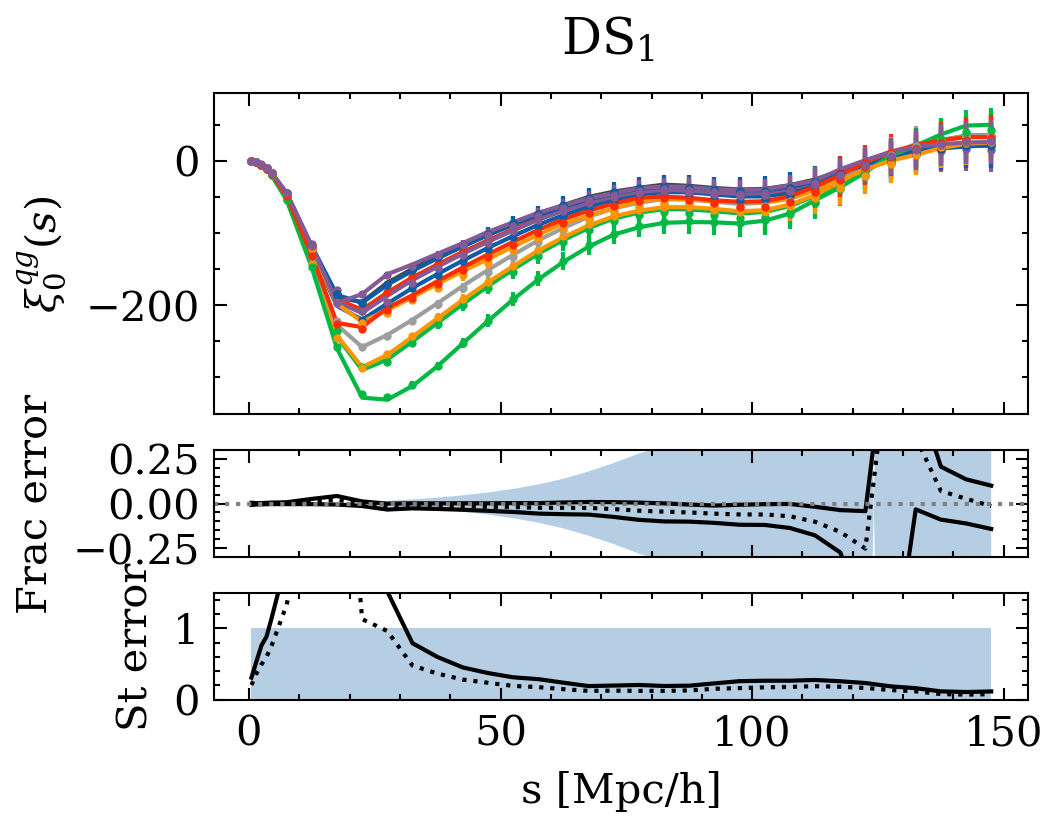

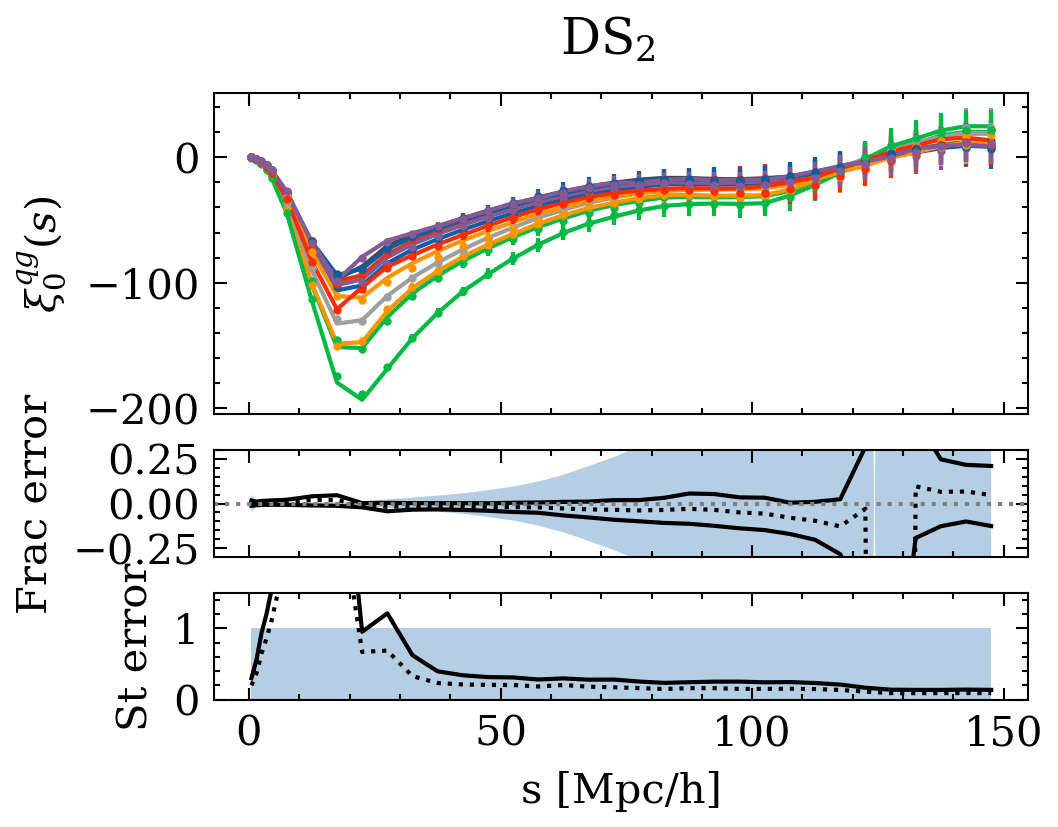

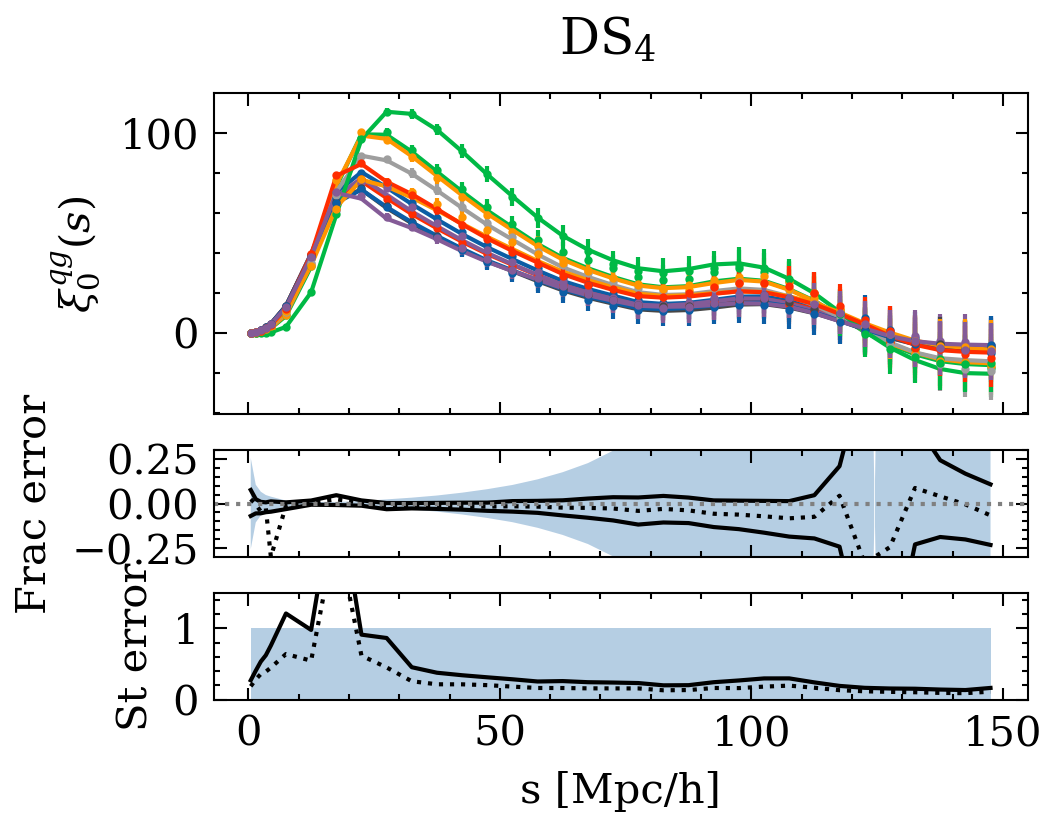

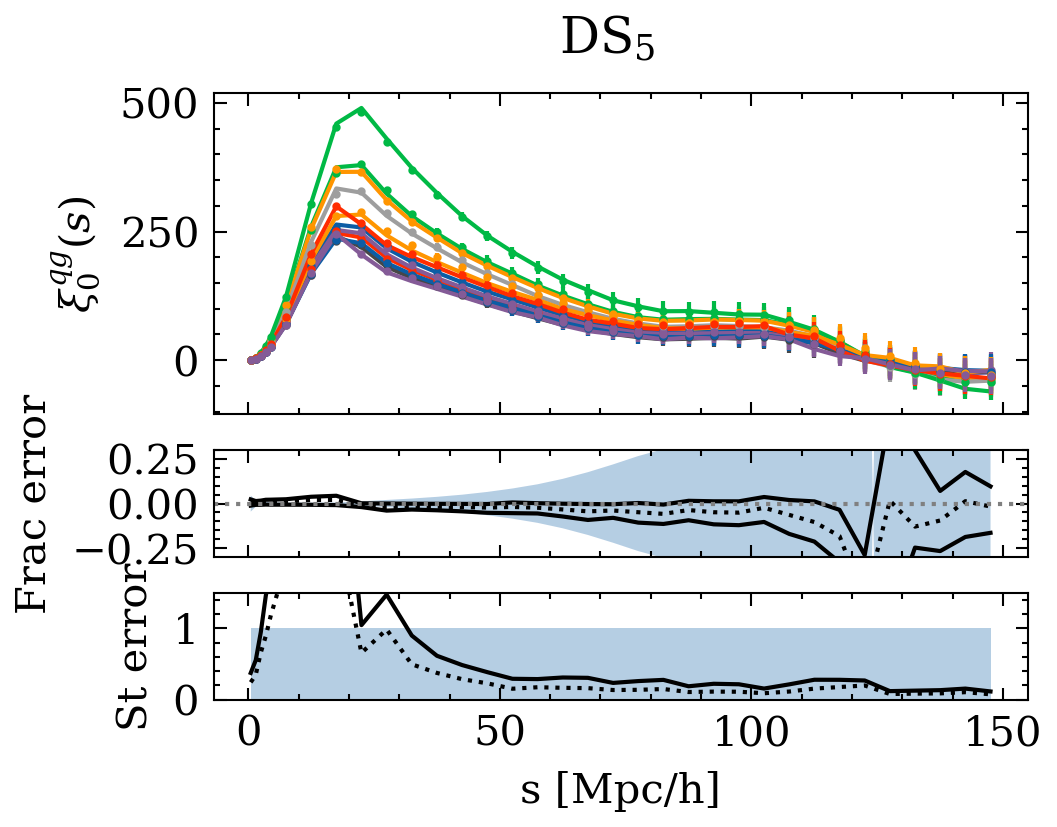

In [11]:
for i, quintile in enumerate([0,1,3,4]):
    fig, ax = plt.subplots(nrows=3, gridspec_kw={'height_ratios': [3, 1, 1]}, sharex=True,)# figsize=(5,4))
    for j in range(0,truths.shape[1], 600):
        c = ax[0].errorbar(s, s**2*truths[i,j], yerr=s**2*errors[i], linestyle='', marker='o', markersize=1)
        ax[0].plot(s, s**2*preds[i,j], color=c[0].get_color())
    mean_error = np.mean(percent_errors[i], axis=0)
    err_frac_p16 = np.percentile(percent_errors[i], 16, axis=0)
    err_frac_p84 = np.percentile(percent_errors[i], 84, axis=0)
    err_frac_inner68 = (err_frac_p84 - err_frac_p16)/2.0
    ax[1].plot(s, mean_error, color='black', linestyle='dotted')
    ax[1].plot(s, err_frac_p16, color='black')
    ax[1].plot(s,  err_frac_p84, color='black')
    ax[1].fill_between(s, -scaled_errors[i], scaled_errors[i], alpha=0.3)
    ax[1].axhline(y=0, color='gray', linestyle='dotted')
    ax[1].set_ylim(-0.3,0.3)


    err_68 = np.percentile(np.abs(standard_errors[i]), 68, axis=0)
    ax[2].plot(s, np.median(np.abs(standard_errors[i]),axis=0), color='black', linestyle='dotted')
    ax[2].plot(s, err_68,
               color='black',) 

    ax[2].fill_between(s, 0, 1, alpha=0.3)
    ax[2].set_ylim(0,1.5)


    fig.suptitle(f'$\mathrm{{DS}}_{quintile+1}$')
    ax[2].set_xlabel('s [Mpc/h]')
    ax[1].set_ylabel('Frac error')
    ax[2].set_ylabel('St error')
    ax[0].set_ylabel(r'$\xi^{{qg}}_{{0}}(s)$')
    plt.show()



In [12]:
# do everything for c000
def read_multipoles(cosmo_idx, quintile=0, multipole=0,):
    data = np.load(
        f'../data/full_ap/clustering/ds_cross_xi_smu_zsplit_Rs20_c{str(cosmo_idx).zfill(3)}_ph000.npy', 
        allow_pickle=True,
    ).item()
    return np.mean(data['multipoles'], axis=1)[:,quintile, multipole]

def read_params(cosmo_idx):
    params = pd.read_csv(f'../data/full_ap/cosmologies/AbacusSummit_c{str(cosmo_idx).zfill(3)}_hod1000.csv')
    return params.to_numpy()



In [13]:
ds = DensitySplit()

In [14]:
hod_idx = 60
params = torch.tensor(read_params(0)[hod_idx], dtype=torch.float32).reshape(1,-1)

In [15]:
pred = ds.get_for_sample(inputs=params)

In [16]:
ds.get_for_batch_inputs(inputs=params,s_min=4.).shape

(4, 30)

In [17]:
planck_multipoles = []
for quintile in [0,1,3,4]:
    planck_multipoles.append(read_multipoles(0,quintile)[hod_idx])
planck_multipoles = np.array(planck_multipoles)

Text(0.5, 0.98, 'Planck BF')

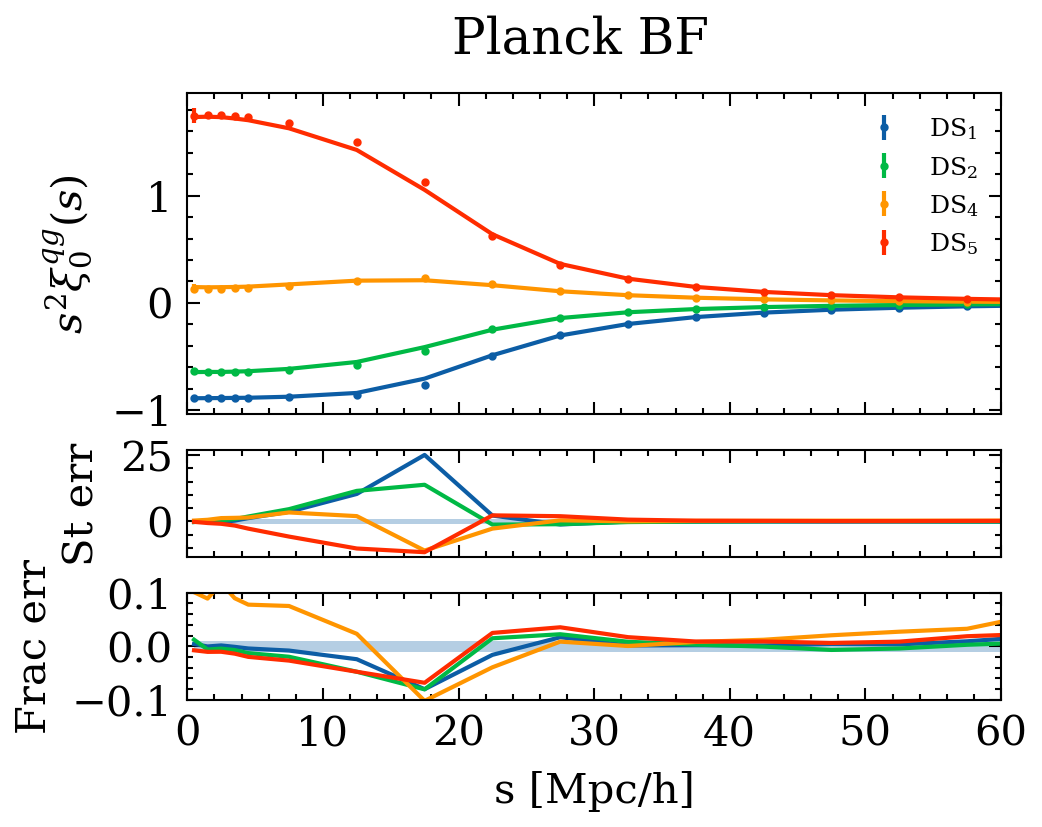

In [18]:
fig, ax = plt.subplots(nrows=3, gridspec_kw={'height_ratios': [3, 1, 1]}, sharex=True,)
for q in [0,1,2,3]:
    c = ax[0].errorbar(s, planck_multipoles[q], yerr=errors[q], linestyle='', marker='o', markersize=1,
                       label=f'$\mathrm{{DS}}_{q+1}$' if (q == 0 or q == 1) else f'$\mathrm{{DS}}_{q+2}$',
    )
    ax[0].plot(s, pred[q], color=c[0].get_color())
    ax[1].plot(s, (pred[q]- planck_multipoles[q])/errors[q])
    ax[2].plot(s, (pred[q]- planck_multipoles[q])/planck_multipoles[q])
ax[1].fill_between(s, -1, 1, alpha=0.3,) 
ax[2].fill_between(s, -0.01, 0.01, alpha=0.3,) 
ax[0].legend(fontsize=6)
ax[0].set_xlim(0,60)
ax[2].set_ylim(-0.1,0.1)
ax[2].set_xlabel('s [Mpc/h]')
ax[1].set_ylabel('St err')
ax[2].set_ylabel('Frac err')
ax[0].set_ylabel(r'$s^2 \xi^{{qg}}_{{0}}(s)$')
fig.suptitle('Planck BF')

Text(0.5, 0.98, 'Planck BF')

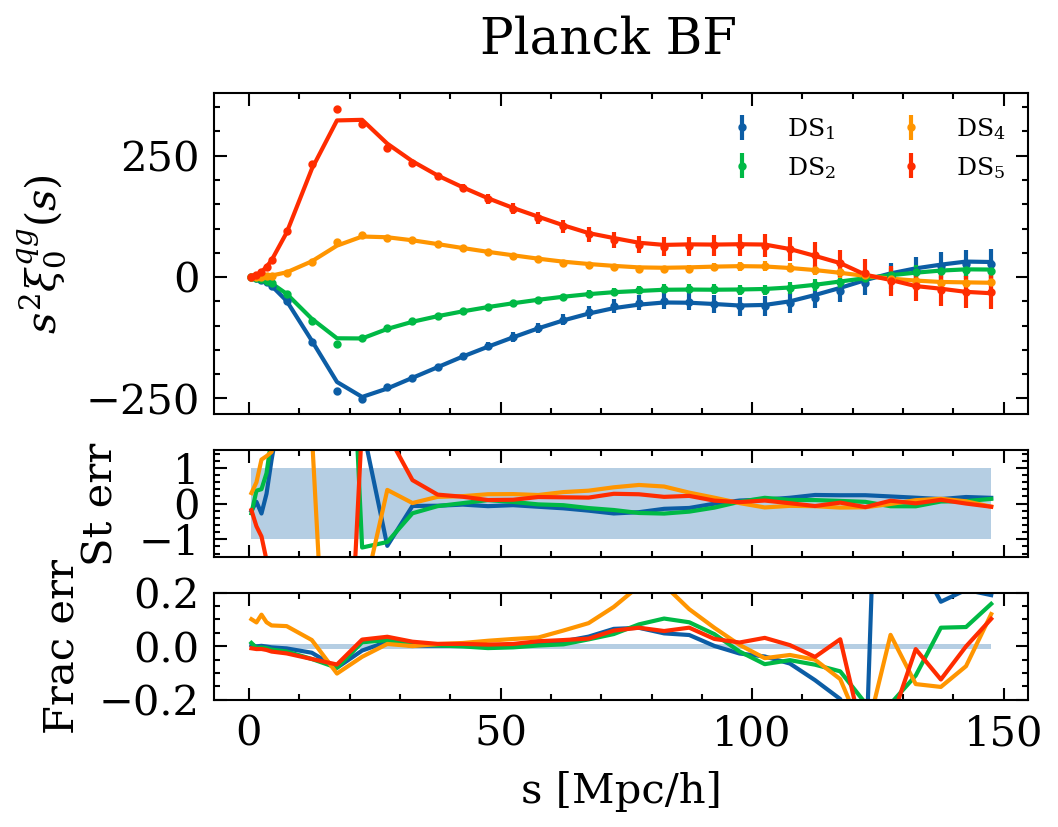

In [19]:
fig, ax = plt.subplots(nrows=3, gridspec_kw={'height_ratios': [3, 1, 1]}, sharex=True,)
for q in [0,1,2,3]:
    c = ax[0].errorbar(s, s**2*planck_multipoles[q], yerr=s**2*errors[q], linestyle='', marker='o', markersize=1,
            label=f'$\mathrm{{DS}}_{q+1}$' if (q == 0 or q == 1) else f'$\mathrm{{DS}}_{q+2}$',
    )
    ax[0].plot(s, s**2*pred[q], color=c[0].get_color())
    ax[1].plot(s, (pred[q]- planck_multipoles[q])/errors[q])
    ax[2].plot(s, (pred[q]- planck_multipoles[q])/planck_multipoles[q])
ax[1].fill_between(s, -1, 1, alpha=0.3,) 
ax[2].fill_between(s, -0.01, 0.01, alpha=0.3,) 
ax[0].legend(fontsize=6, ncol=2)
ax[2].set_ylim(-0.2,0.2)
ax[1].set_ylim(-1.5,1.5)
ax[2].set_xlabel('s [Mpc/h]')
ax[1].set_ylabel('St err')
ax[2].set_ylabel('Frac err')
ax[0].set_ylabel(r'$s^2 \xi^{{qg}}_{{0}}(s)$')
fig.suptitle('Planck BF')